In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import openbrewerydb as obdb

In [149]:
df_beers = pd.read_csv('C:/Users/ryank/Projects/Beer Data Analysis/Data/beers.csv')
df_breweries = pd.read_csv('C:/Users/ryank/Projects/Beer Data Analysis/Data/breweries.csv')

### An Initial Peek at our data

In [155]:
# How big are each of these datasets?
print("beers dataset length & number of columns:" , df_beers.shape)
print("breweries dataset length:" , df_breweries.shape)

beers dataset length & number of columns: (2410, 7)
breweries dataset length: (558, 3)


In [156]:
df_beers.head()

,abv,ibu,id,name,style,brewery_id,ounces
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [157]:
df_breweries.head()

,name,city,state
0,NorthGate Brewing,Minneapolis,MN
1,Against the Grain Brewery,Louisville,KY
2,Jack's Abby Craft Lagers,Framingham,MA
3,Mike Hess Brewing Company,San Diego,CA
4,Fort Point Beer Company,San Francisco,CA


In [158]:
# What datatypes are in these datasets?
print(df_beers.info())
print(df_breweries.info())

# Initial summary statistics for the beers dataset
round(df_beers[['abv', 'ibu', 'ounces']].describe(include='all'), 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   abv         2348 non-null   float64
 1   ibu         1405 non-null   float64
 2   id          2410 non-null   int64  
 3   name        2410 non-null   object 
 4   style       2405 non-null   object 
 5   brewery_id  2410 non-null   int64  
 6   ounces      2410 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 131.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    558 non-null    object
 1   city    558 non-null    object
 2   state   558 non-null    object
dtypes: object(3)
memory usage: 13.2+ KB
None


,abv,ibu,ounces
count,2348.00,1405.00,2410.00
mean,0.06,42.71,13.59
std,0.01,25.95,2.35
min,0.00,4.00,8.40
25%,0.05,21.00,12.00
50%,0.06,35.00,12.00
75%,0.07,64.00,16.00
max,0.13,138.00,32.00


In [160]:
# look for null values in the data
print(df_beers.isna().any())
print(df_breweries.isna().any())

# Where are the null values in the beer dataset and how many are there?
print(df_beers.isnull().sum())

abv            True
ibu            True
id            False
name          False
style          True
brewery_id    False
ounces        False
dtype: bool
name     False
city     False
state    False
dtype: bool
abv             62
ibu           1005
id               0
name             0
style            5
brewery_id       0
ounces           0
dtype: int64


### Data Cleaning

In [162]:
# Address missing data

# Let's roll up the beers data by beer style and get a mean value for ABV and IBU.
# We will insert this into the null values in our main dataset based on a beer's beer style
means_bystyle = df_beers.groupby(by="style", dropna=False).mean(numeric_only=True).drop(columns=["id", "brewery_id", "ounces"]).reset_index()

# There are 9 beer styles with no IBU data
print(means_bystyle.isnull().sum())
print(means_bystyle.query('ibu.isnull()'))

# Some of the beer styles had no IBU data at all.
# We will use IBU data found on BeerAdvocate.
means_bystyle.loc[means_bystyle['style'] == 'American Malt Liquor', 'ibu'] = 20
means_bystyle.loc[means_bystyle['style'] == 'Braggot', 'ibu'] = 30
means_bystyle.loc[means_bystyle['style'] == 'Cider', 'ibu'] = 0
means_bystyle.loc[means_bystyle['style'] == 'Flanders Red Ale', 'ibu'] = 15
means_bystyle.loc[means_bystyle['style'] == 'Kristalweizen', 'ibu'] = 15
means_bystyle.loc[means_bystyle['style'] == 'Low Alcohol Beer', 'ibu'] = 15
means_bystyle.loc[means_bystyle['style'] == 'Mead', 'ibu'] = 0
means_bystyle.loc[means_bystyle['style'] == 'Rauchbier', 'ibu'] = 25
means_bystyle.loc[means_bystyle['style'] == 'Shandy', 'ibu'] = 10
means_bystyle

style    1
abv      0
ibu      9
dtype: int64
                   style       abv  ibu
15  American Malt Liquor  0.099000  NaN
34               Braggot  0.075000  NaN
37                 Cider  0.060514  NaN
57      Flanders Red Ale  0.083000  NaN
68         Kristalweizen  0.045000  NaN
71      Low Alcohol Beer  0.001000  NaN
73                  Mead  0.071600  NaN
84             Rauchbier  0.060500  NaN
92                Shandy  0.045333  NaN


,style,abv,ibu
0,Abbey Single Ale,0.049000,22.000000
1,Altbier,0.054385,34.125000
2,American Adjunct Lager,0.048722,11.000000
3,American Amber / Red Ale,0.057456,36.298701
4,American Amber / Red Lager,0.049464,23.250000
...,...,...,...
95,Vienna Lager,0.051050,24.357143
96,Wheat Ale,0.060000,24.000000
97,Winter Warmer,0.070400,24.625000
98,Witbier,0.053551,16.208333


In [163]:
# Join ABV and ABU averages by style to main beer dataset
df_beers_2 = pd.merge(df_beers, means_bystyle, on='style', how='left', suffixes=('', '_mean'))

# Impute style averages into null values in main beer dataset
df_beers_2['ibu'].fillna(df_beers_2['ibu_mean'], inplace=True)
df_beers_2['abv'].fillna(df_beers_2['abv_mean'], inplace=True)

# Drop columns used to insert average ABV and IBU for each beer style
df_beers_2 = df_beers_2.drop(columns=["abv_mean", "ibu_mean"])


In [164]:
# There are 5 entries where the beer style is null
df_beers_2[df_beers_2["style"].isna()]

# Two of these we can insert style data based on the actual beer name. Drop the other three.
df_beers_2.loc[df_beers_2['name'] == 'Kilt Lifter Scottish-Style Ale', 'style'] = "Scottish-Style Ale"
df_beers_2.loc[df_beers_2['name'] == 'OktoberFiesta', 'style'] = "Märzen / Oktoberfest"
df_beers_2.dropna(subset=['style'], inplace=True)

In [166]:
# The index of the brewery dataset is its brewery id which will be used to bring in brewery data.
# Create a column 'brewery_id' in brewery dataset to have a key to merge on
df_breweries['brewery_id'] = df_breweries.index

# Bring in Brewery names
df = pd.merge(df_beers_2, df_breweries, how='left', on='brewery_id')
df = df.rename(columns={'abv':'ABV', 'ibu':'IBU', 'id':'beer_id', 'name_x':'Beer Name', 'style':'Beer Style', 'name_y':'Brewery Name', 'ounces':'oz', 'city':'City', 'state':'State'})

# Reorder columns
new_order = ['beer_id', 'brewery_id', 'Brewery Name', 'Beer Name', 'Beer Style', 'ABV', 'IBU', 'oz', 'City', 'State']
df = df.reindex(columns=new_order)

# Remove spacing before state codes
df['State'] = df['State'].str.strip()
df

,beer_id,brewery_id,Brewery Name,Beer Name,Beer Style,ABV,IBU,oz,City,State
0,1436,408,10 Barrel Brewing Company,Pub Beer,American Pale Lager,0.050,26.750000,12.0,Bend,OR
1,2265,177,18th Street Brewery,Devil's Cup,American Pale Ale (APA),0.066,44.941176,12.0,Gary,IN
2,2264,177,18th Street Brewery,Rise of the Phoenix,American IPA,0.071,67.634551,12.0,Gary,IN
3,2263,177,18th Street Brewery,Sinister,American Double / Imperial IPA,0.090,93.320000,12.0,Gary,IN
4,2262,177,18th Street Brewery,Sex and Candy,American IPA,0.075,67.634551,12.0,Gary,IN
...,...,...,...,...,...,...,...,...,...,...
2402,928,424,Wynkoop Brewing Company,Belgorado,Belgian IPA,0.067,45.000000,12.0,Denver,CO
2403,807,424,Wynkoop Brewing Company,Rail Yard Ale,American Amber / Red Ale,0.052,36.298701,12.0,Denver,CO
2404,620,424,Wynkoop Brewing Company,B3K Black Lager,Schwarzbier,0.055,31.000000,12.0,Denver,CO
2405,145,424,Wynkoop Brewing Company,Silverback Pale Ale,American Pale Ale (APA),0.055,40.000000,12.0,Denver,CO


### Visualization

Now that we have the data cleaned up, joined and organized, let's take a look into what the data is telling us.

What State has the most breweries?

What are the average ABVs and IBUs by beer style?
    -ABV: Alcohol By volume
    -IBU: Internation Bittering Unit, IE how bitter the hops make the beer


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [ 0. 10. 20. 30. 40. 50.]


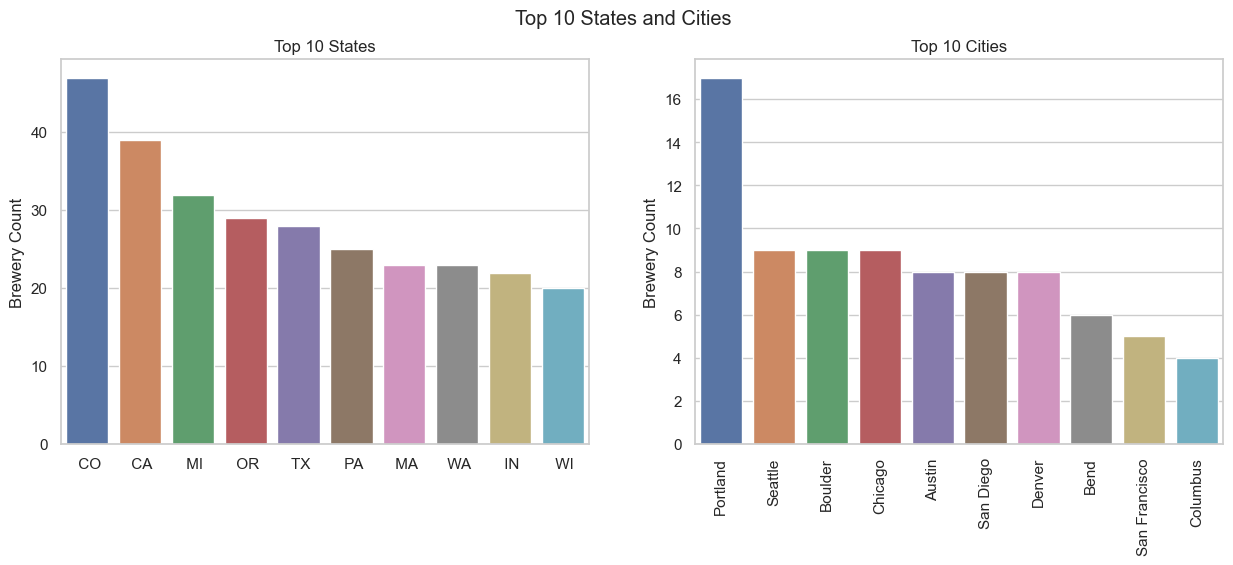

In [192]:
# Create data to use for a Histogram for brewreies by State & City
brewery_countsbystate = df_breweries['state'].value_counts().rename_axis('State').reset_index(name='Brewery Count')
brewery_countsbycity = df_breweries['city'].value_counts().rename_axis('City').reset_index(name='Brewery Count')

fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.set_theme(style="whitegrid")
fig.suptitle('Top 10 States and Cities')
    
# Top 10 States
sns.barplot(ax=axes[0], x="State", y="Brewery Count", data=brewery_countsbystate.head(10), palette='deep')
axes[0].set_title("Top 10 States")
axes[0].set_xlabel("")  # Suppress bottom label

# Top 10 Cities
sns.barplot(ax=axes[1], x="City", y="Brewery Count", data=brewery_countsbycity.head(10), palette='deep')
axes[1].set_title("Top 10 Cities")
axes[1].set_xlabel("")  # Suppress bottom label
plt.xticks(rotation=90)

# Print the x and y ticks of the first subplot
print(axes[0].get_xticks(), axes[0].get_yticks())

In [169]:
df.head()

,beer_id,brewery_id,Brewery Name,Beer Name,Beer Style,ABV,IBU,oz,City,State
0,1436,408,10 Barrel Brewing Company,Pub Beer,American Pale Lager,0.050,26.750000,12.0,Bend,OR
1,2265,177,18th Street Brewery,Devil's Cup,American Pale Ale (APA),0.066,44.941176,12.0,Gary,IN
2,2264,177,18th Street Brewery,Rise of the Phoenix,American IPA,0.071,67.634551,12.0,Gary,IN
3,2263,177,18th Street Brewery,Sinister,American Double / Imperial IPA,0.090,93.320000,12.0,Gary,IN
4,2262,177,18th Street Brewery,Sex and Candy,American IPA,0.075,67.634551,12.0,Gary,IN


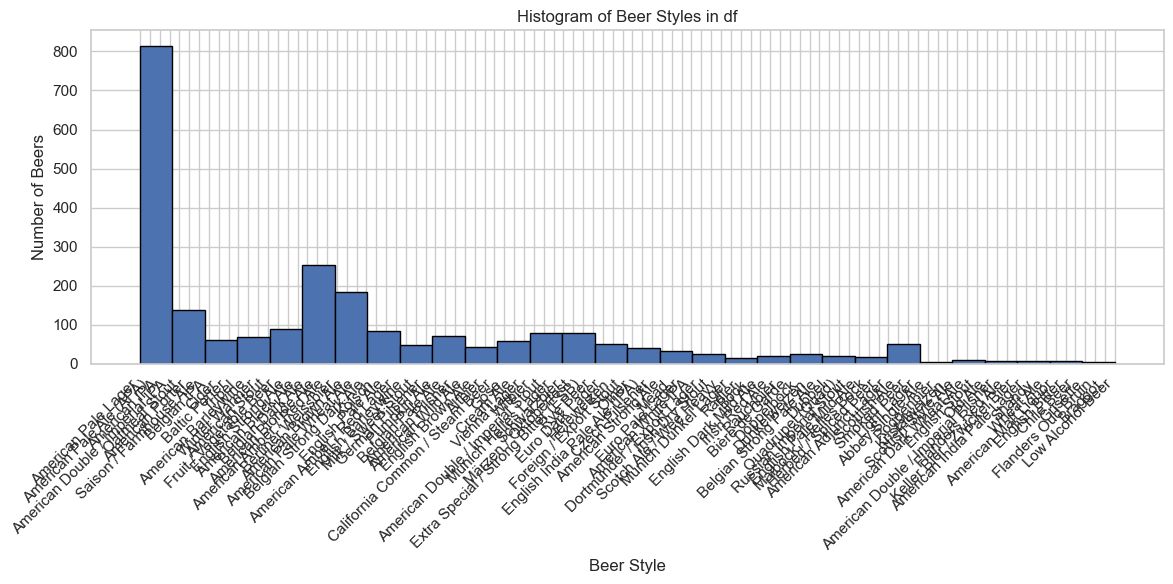

In [170]:
# Create the histogram
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.hist(df["Beer Style"], bins=30, edgecolor="black")
plt.xlabel("Beer Style")
plt.ylabel("Number of Beers")
plt.title("Histogram of Beer Styles in df")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

# Display the histogram
plt.show()
